In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results

In [2]:
# load results
experiment, result = load_results('uncertainty_rerun.tar.gz')
results = pd.read_csv('03_MORO_results.csv')
inputs = results.iloc[:,:32]
outcomes = results.iloc[:,32:]

In [3]:
outcomes = outcomes.rename(columns={"Expected_Damage":"Expected Damage", "Dike_Costs":"Cost for dike heigthening","RfR_Costs":"Cost for Room for the River", "Evacuation_Costs":"Cost of Evacuation", "Number_of_Deaths":"Expected number of deaths", "wl":"Minimum Waterlevel"})

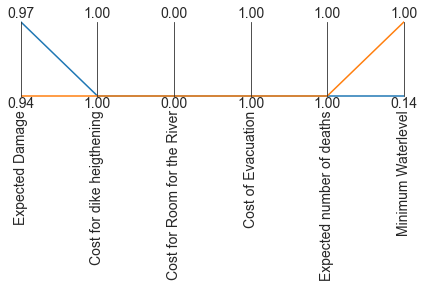

In [4]:
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [5]:
results_pol1 = pd.DataFrame()
results_pol2 = pd.DataFrame()
results_pol1['Expected Annual Damage'] = result['Expected Annual Damage'][:1000]
results_pol2['Expected Annual Damage'] = result['Expected Annual Damage'][1000:]
results_pol1['Dike Investment Costs'] = result['Dike Investment Costs'][:1000]
results_pol2['Dike Investment Costs'] = result['Dike Investment Costs'][1000:]
results_pol1['RfR Investment Costs'] = result['RfR Investment Costs'][:1000]
results_pol2['RfR Investment Costs'] = result['RfR Investment Costs'][1000:]
results_pol1['Evacuation Costs'] = result['Evacuation Costs'][:1000]
results_pol2['Evacuation Costs'] = result['Evacuation Costs'][1000:]
results_pol1['Expected Number of Deaths'] = result['Expected Number of Deaths'][:1000]
results_pol2['Expected Number of Deaths'] = result['Expected Number of Deaths'][1000:]
results_pol1['Minimum water level full network'] = result['Minimum water level full network'][:1000]
results_pol2['Minimum water level full network'] = result['Minimum water level full network'][1000:]

objectives = ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs',
              'Expected Number of Deaths','Minimum water level full network']

In [6]:
# Robustness metrics
def hurwitz(data,column_names,alpha=0):
    '''weighs off the best and worst payoffs'''
    results = {}
    
    for column_name in column_names:
        Max_value = data[column_name].max()
        Min_value = data[column_name].min()

        #calculate hurwitz coefficient as described in Arrow (1972)
        hurwitz_coef = alpha * Max_value + (1-alpha) * Min_value
        results[column_name] = hurwitz_coef
    
    
    return results

def mean_variance(data,column_names):
    '''for maximization this is defined as the mean divided by the standard deviation (Kwakkel et al, 2019)'''
    results = {}
    
    for column_name in column_names:
        mean_value = data[column_name].mean()
        std_value = data[column_name].std()
        if abs(std_value) < 0.001:
            mv_coef = 0
        else:
            mv_coef = mean_value/std_value
        results[column_name] = mv_coef
    
    return results

def quartile_skewedness(data,column_names):
    '''returns the quartile that contains the most observations'''
    results = {}
    Values = {}
    for column_name in column_names:
        #place all results in four equally spaced bins
        data['MyQuantileBins'] =  pd.cut(data[column_name], 4)
        values = data['MyQuantileBins'].value_counts()
        Values[column_name] = values
        #determine which quartile (bin) is overrepresented (contains the most values)
        for i in range(3):
            if max(values) == values[i]:
                #save the quartile and the percentage of values it contains in a dictionary
                results[column_name] = (i+1,(values[i]/values.sum()))    
    return results, Values

In [18]:
pol1Hur0 = hurwitz(results_pol1,objectives,0)
pol1Hur0_5 = hurwitz(results_pol1,objectives,0.5)
pol1Hur1 = hurwitz(results_pol1,objectives,1)
hur1 = [pol1Hur0,pol1Hur0_5,pol1Hur1]

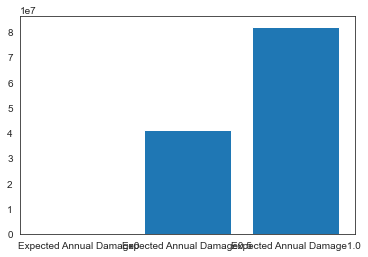

{'Expected Annual Damage0': 0.0, 'Expected Annual Damage0.5': 40994241.201930486, 'Expected Annual Damage1.0': 81988482.40386097}


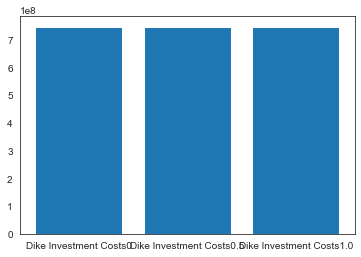

{'Dike Investment Costs0': 746831863.6008537, 'Dike Investment Costs0.5': 746831863.6008537, 'Dike Investment Costs1.0': 746831863.6008537}


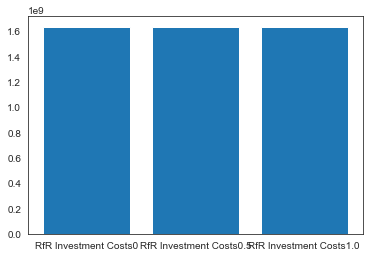

{'RfR Investment Costs0': 1635000000.0, 'RfR Investment Costs0.5': 1635000000.0, 'RfR Investment Costs1.0': 1635000000.0}


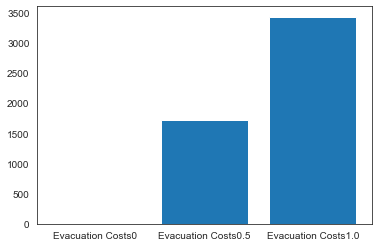

{'Evacuation Costs0': 0.0, 'Evacuation Costs0.5': 1713.7601702338116, 'Evacuation Costs1.0': 3427.520340467623}


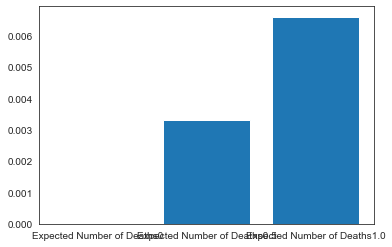

{'Expected Number of Deaths0': 0.0, 'Expected Number of Deaths0.5': 0.0033008786149177393, 'Expected Number of Deaths1.0': 0.0066017572298354785}


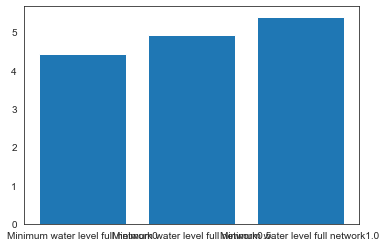

{'Minimum water level full network0': 4.418353787064368, 'Minimum water level full network0.5': 4.907968875781964, 'Minimum water level full network1.0': 5.397583964499559}


In [28]:
#makes a dict of hurwitz values of alpha=0,0.5,1 for each column and then plots the dict
for i in objectives:
    metric = {}
    counter = 0
    for j in hur1:
        metric[i + str(counter)] = j[i]
        counter += 0.5
    plt.bar(range(len(metric)), list(metric.values()), align='center')
    plt.xticks(range(len(metric)), list(metric.keys()))
    plt.show()
    print(metric)

{'Minimum water level full network': 5.397583964499559}

In [8]:
pol2dictHur = hurwitz(results_pol2,objectives)
pol2dictHur

{'Expected Annual Damage': 0.0,
 'Dike Investment Costs': 822714507.6447108,
 'RfR Investment Costs': 953000000.0,
 'Evacuation Costs': 0.0,
 'Expected Number of Deaths': 0.0,
 'Minimum water level full network': 4.538353787064368}

In [9]:
pol1dictMv = mean_variance(results_pol1,objectives)
pol1dictMv

{'Expected Annual Damage': 0.06149643929027164,
 'Dike Investment Costs': 0,
 'RfR Investment Costs': 0,
 'Evacuation Costs': 0.07505424864173875,
 'Expected Number of Deaths': 0,
 'Minimum water level full network': 27.264516647789534}

In [10]:
pol2dictMv = mean_variance(results_pol2,objectives)
pol2dictMv

{'Expected Annual Damage': 0.13324424513365524,
 'Dike Investment Costs': 0,
 'RfR Investment Costs': 0,
 'Evacuation Costs': 0.1279987401105003,
 'Expected Number of Deaths': 0.1306221323964535,
 'Minimum water level full network': 27.995701425831573}

In [11]:
pol1dictQs, pol1dictQsval = quartile_skewedness(results_pol1,objectives)
pol1dictQs

{'Expected Annual Damage': (1, 0.999),
 'Dike Investment Costs': (1, 1.0),
 'RfR Investment Costs': (1, 1.0),
 'Evacuation Costs': (1, 0.996),
 'Expected Number of Deaths': (1, 0.996),
 'Minimum water level full network': (1, 0.894)}

In [12]:
pol2dictQs, pol2dictQsval = quartile_skewedness(results_pol2,objectives)
pol2dictQsval

{'Expected Annual Damage': (-45294.16, 11323540.092]       991
 (11323540.092, 22647080.184]      5
 (33970620.276, 45294160.368]      2
 (22647080.184, 33970620.276]      2
 Name: MyQuantileBins, dtype: int64,
 'Dike Investment Costs': (822303150.391, 822714507.645]    1000
 (823125864.899, 823537222.152]       0
 (822714507.645, 823125864.899]       0
 (821891793.137, 822303150.391]       0
 Name: MyQuantileBins, dtype: int64,
 'RfR Investment Costs': (952523500.0, 953000000.0]    1000
 (953476500.0, 953953000.0]       0
 (953000000.0, 953476500.0]       0
 (952047000.0, 952523500.0]       0
 Name: MyQuantileBins, dtype: int64,
 'Evacuation Costs': (-1.535, 383.855]       990
 (383.855, 767.71]         6
 (1151.565, 1535.419]      3
 (767.71, 1151.565]        1
 Name: MyQuantileBins, dtype: int64,
 'Expected Number of Deaths': (-1.67e-05, 0.00417]    990
 (0.00417, 0.00833]        6
 (0.0125, 0.0167]          3
 (0.00833, 0.0125]         1
 Name: MyQuantileBins, dtype: int64,
 'Minim

Text(0.5, 1.0, 'water level distribution')

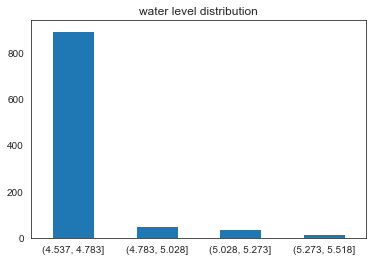

In [13]:
pol2dictQsval['Minimum water level full network'].plot(kind='bar')
plt.xticks(rotation = 0)
plt.title('water level distribution')

Text(0.5, 1.0, 'water level distribution')

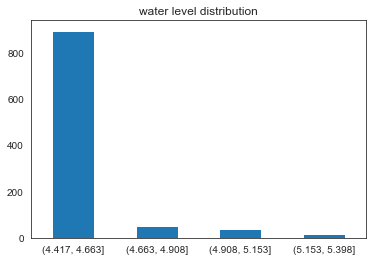

In [14]:
pol1dictQsval['Minimum water level full network'].plot(kind='bar')
plt.xticks(rotation = 0)
plt.title('water level distribution')